In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!pip install matplotlib --quiet

In [11]:
!pip install hmmlearn --quiet

In [12]:
# Import libraries for data manipulation and analysis
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [13]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

# Preprocessing

---



In [14]:
# Read datafile
data = pd.read_csv('/content/drive/MyDrive/PTDLKD/Data/Platinum_Data.csv')
data=data.set_index(pd.DatetimeIndex(data['Date'].values))

# Flip the column
data = data.iloc[::-1]

# Format column Price to float
data['Price'] = data.Price.str.replace(',','').astype(float)

# Format column Date
data.Date = pd.to_datetime(data.Date,format='%m/%d/%Y')

# Drop column that aren't use
data.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis = 1, inplace=True)

df = pd.DataFrame(data, columns=['Date', 'Price'])
df.drop('Date', axis = 1, inplace = True)

In [15]:
# Create a MinMaxScaler object with a specified range
scaler = MinMaxScaler()
data = scaler.fit_transform(np.array(df["Price"]).reshape(-1, 1))

# Spilt Dataset (7-2-1)

---



In [16]:
# Split the data
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [17]:

lowest_mse = 99999
best_params = {}

for n_components in [2, 3, 4, 5, 6, 7, 8, 9]:
    for covariance_type in ["diag", "full", "tied"]:
      for i in range(1, 100):
        model = GaussianHMM(n_components=n_components, covariance_type=covariance_type, random_state = i)
        model.fit(train_data)
        y_pred, _ = model.sample(len(test_data))
        mse = mean_squared_error(scaler.inverse_transform(test_data), scaler.inverse_transform(y_pred.reshape(-1,1)))

        # Update the best parameters if the score improves
        if mse < lowest_mse:
            lowest_mse = mse
            best_params = {
                "n_components": n_components,
                "covariance_type": covariance_type,
                "random_state": i
            }

In [18]:
# Train the HMM model with the best parameters
model = GaussianHMM(**best_params, n_iter=100)
model.fit(train_data)

GaussianHMM(covariance_type='tied', n_components=9, n_iter=100, random_state=15)

In [19]:
all_pred, _ = model.sample(test_size+val_size+30)
all_pred = scaler.inverse_transform(all_pred.reshape(-1,1))
test_pred = all_pred[:test_size]
val_pred = all_pred[test_size:test_size+val_size]
thirty_day_pred = all_pred[test_size+val_size:]

In [20]:
# Predict 30 days
new_index = pd.date_range(start=df.index[-1], periods=31, freq='D')[1:]
df1 = df.reindex(df.index.union(new_index))

df1.fillna(0, inplace=True)

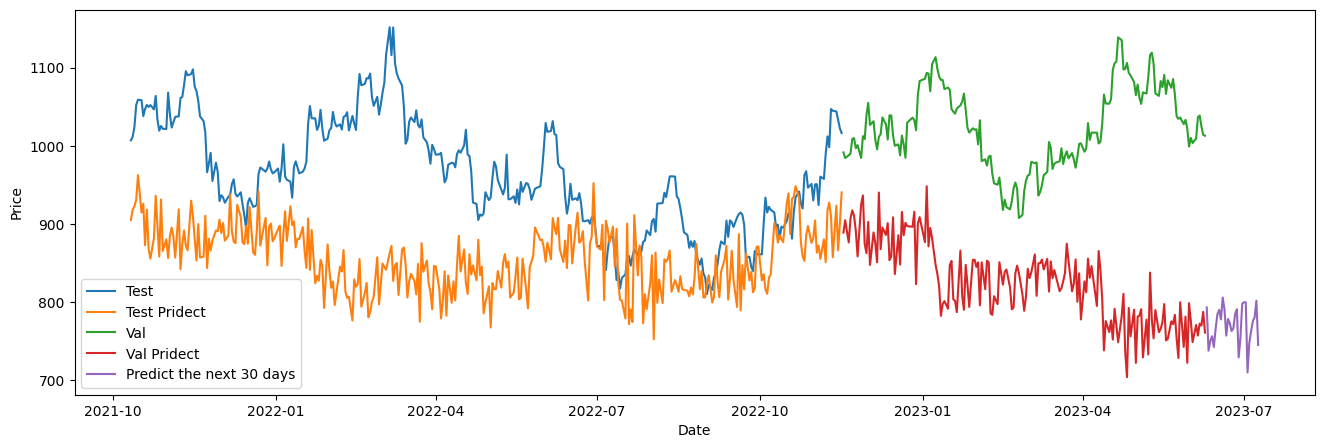

In [21]:
train = df[:train_size]
test = df[train_size:train_size+test_size]
validate = df[train_size+test_size:]

# Plot the model
plt.figure(figsize=(16,5))

plt.plot(test.index, test.Price, label='Test')
plt.plot(test.index, test_pred, label='Test Pridect')
plt.plot(validate.index, validate.Price, label='Val')
plt.plot(validate.index, val_pred, label='Val Pridect')
plt.plot(df1.index[-30:], thirty_day_pred, label='Predict the next 30 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [22]:
y_test = scaler.inverse_transform(test_data)
y_val = scaler.inverse_transform(val_data)
evaluateModel(y_test,test_pred,y_val,val_pred)

** Testing **
MAE:  109.66621061215993
MAPE:  10.995776687065701
RMSE:  131.4136067022423

** Validate **
MAE:  197.98414392337776
MAPE:  19.09651737696843
RMSE:  214.07936490769205


# Spilt Dataset (6-3-1)

---



In [23]:
# Split the data
train_size = int(0.6 * len(data))
test_size = int(0.3 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [24]:

lowest_mse = 99999
best_params = {}

for n_components in [2, 3, 4, 5, 6, 7, 8, 9]:
    for covariance_type in ["diag", "full", "tied"]:
      for i in range(1, 100):
        model = GaussianHMM(n_components=n_components, covariance_type=covariance_type, random_state = i)
        model.fit(train_data)
        y_pred, _ = model.sample(len(test_data))
        mse = mean_squared_error(scaler.inverse_transform(test_data), scaler.inverse_transform(y_pred.reshape(-1,1)))

        # Update the best parameters if the score improves
        if mse < lowest_mse:
            lowest_mse = mse
            best_params = {
                "n_components": n_components,
                "covariance_type": covariance_type,
                "random_state": i
            }

In [25]:
# Train the HMM model with the best parameters
model = GaussianHMM(**best_params, n_iter=100)
model.fit(train_data)

GaussianHMM(covariance_type='tied', n_components=8, n_iter=100, random_state=67)

In [26]:
all_pred, _ = model.sample(test_size+val_size+30)
all_pred = scaler.inverse_transform(all_pred.reshape(-1,1))
test_pred = all_pred[:test_size]
val_pred = all_pred[test_size:test_size+val_size]
thirty_day_pred = all_pred[test_size+val_size:]

In [27]:
# Predict 30 days
new_index = pd.date_range(start=df.index[-1], periods=31, freq='D')[1:]
df1 = df.reindex(df.index.union(new_index))

df1.fillna(0, inplace=True)

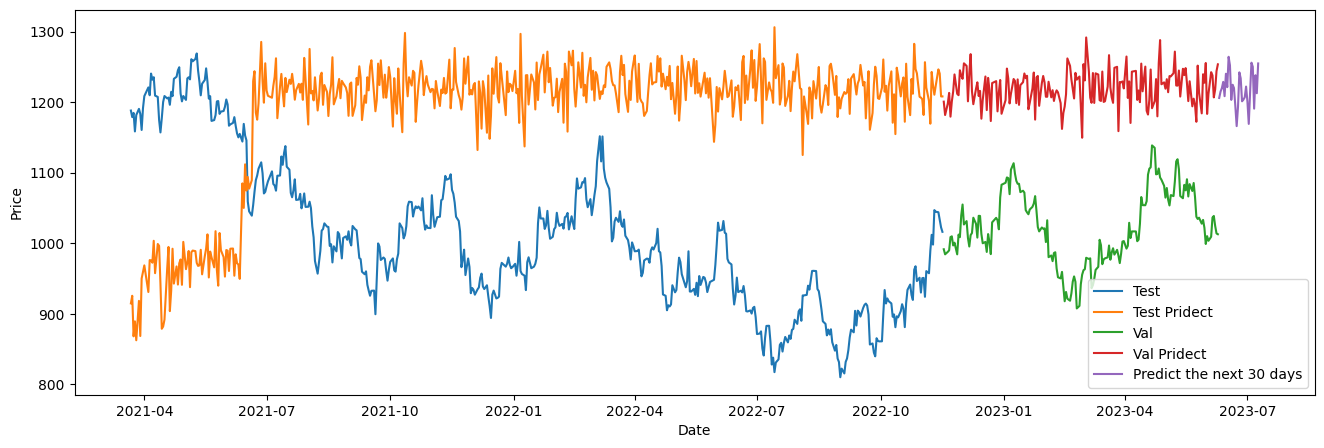

In [28]:
train = df[:train_size]
test = df[train_size:train_size+test_size]
validate = df[train_size+test_size:]

# Plot the model
plt.figure(figsize=(16,5))

plt.plot(test.index, test.Price, label='Test')
plt.plot(test.index, test_pred, label='Test Pridect')
plt.plot(validate.index, validate.Price, label='Val')
plt.plot(validate.index, val_pred, label='Val Pridect')
plt.plot(df1.index[-30:], thirty_day_pred, label='Predict the next 30 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [29]:
y_test = scaler.inverse_transform(test_data)
y_val = scaler.inverse_transform(val_data)
evaluateModel(y_test,test_pred,y_val,val_pred)

** Testing **
MAE:  242.86558212308418
MAPE:  24.815445309472477
RMSE:  254.03855205342404

** Validate **
MAE:  197.5426430167709
MAPE:  19.603868848275063
RMSE:  204.9782801119218


# Spilt Dataset (5-3-2)

---



In [30]:
# Split the data
train_size = int(0.5 * len(data))
test_size = int(0.3 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [31]:

lowest_mse = 99999
best_params = {}

for n_components in [2, 3, 4, 5, 6, 7, 8, 9]:
    for covariance_type in ["diag", "full", "tied"]:
      for i in range(1, 100):
        model = GaussianHMM(n_components=n_components, covariance_type=covariance_type, random_state = i)
        model.fit(train_data)
        y_pred, _ = model.sample(len(test_data))
        mse = mean_squared_error(scaler.inverse_transform(test_data), scaler.inverse_transform(y_pred.reshape(-1,1)))

        # Update the best parameters if the score improves
        if mse < lowest_mse:
            lowest_mse = mse
            best_params = {
                "n_components": n_components,
                "covariance_type": covariance_type,
                "random_state": i
            }

In [32]:
# Train the HMM model with the best parameters
model = GaussianHMM(**best_params, n_iter=100)
model.fit(train_data)

GaussianHMM(covariance_type='tied', n_components=7, n_iter=100, random_state=41)

In [33]:
all_pred, _ = model.sample(test_size+val_size+30)
all_pred = scaler.inverse_transform(all_pred.reshape(-1,1))
test_pred = all_pred[:test_size]
val_pred = all_pred[test_size:test_size+val_size]
thirty_day_pred = all_pred[test_size+val_size:]

In [34]:
# Predict 30 days
new_index = pd.date_range(start=df.index[-1], periods=31, freq='D')[1:]
df1 = df.reindex(df.index.union(new_index))

df1.fillna(0, inplace=True)

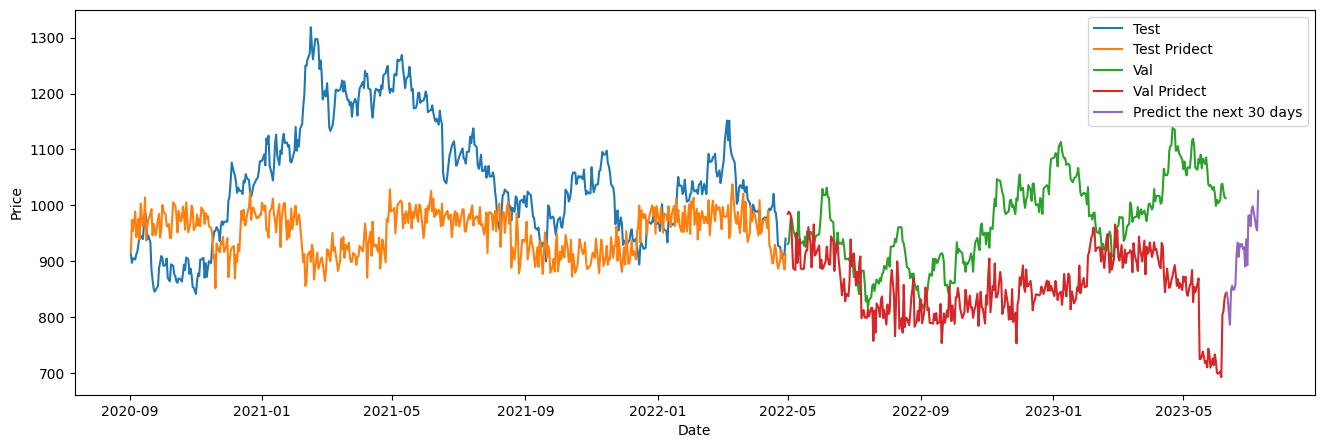

In [35]:
train = df[:train_size]
test = df[train_size:train_size+test_size]
validate = df[train_size+test_size:]

# Plot the model
plt.figure(figsize=(16,5))

plt.plot(test.index, test.Price, label='Test')
plt.plot(test.index, test_pred, label='Test Pridect')
plt.plot(validate.index, validate.Price, label='Val')
plt.plot(validate.index, val_pred, label='Val Pridect')
plt.plot(df1.index[-30:], thirty_day_pred, label='Predict the next 30 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [36]:
y_test = scaler.inverse_transform(test_data)
y_val = scaler.inverse_transform(val_data)
evaluateModel(y_test,test_pred,y_val,val_pred)

** Testing **
MAE:  117.04824522540798
MAPE:  10.618123334219478
RMSE:  149.08795039947768

** Validate **
MAE:  119.53316777906804
MAPE:  11.880200552588995
RMSE:  147.64343833811378


# Evaluate model

---
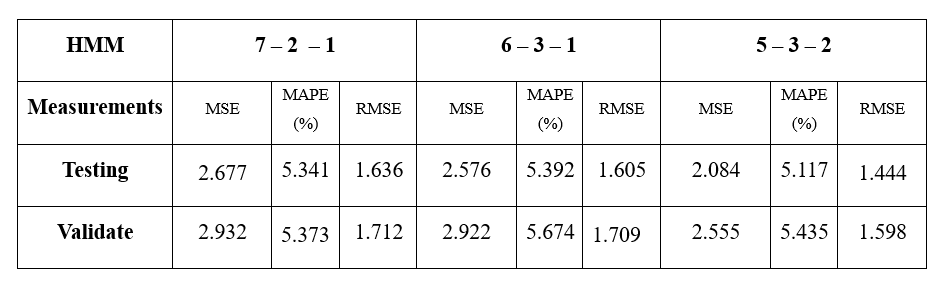
